In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd

from fsvc_watermarking import fsvc_watermark_embedding, fsvc_watermark_detection
from patchwork_watermarking import patchwork_watermark_embedding, patchwork_watermark_detection
from norm_space_watermarking import norm_space_watermark_embedding, norm_space_watermark_detection
from dct_watermarking import get_watermark_length, dctb1_watermark_embedding, dctb1_watermark_detection
import warnings
warnings.filterwarnings("ignore")

# Audio Watermarking

Autores:
- Pablo Smolkin
- Francisco Ledesma

La marca de agua de audio es una técnica que permite incrustar información no audible, o apenas audible, en una señal de audio, de manera que no se pueda eliminar sin degradar la señal de audio original

## Metricas

### Bit Error Rate

\begin{equation*}
BER = \frac{1}{N} \sum_{i=1}^{N} w_i \oplus \hat{w}_i
\end{equation*}

* N es el número total de bits en la marca de agua.
* $w_i$ es el i-ésimo bit de la secuencia original.
* $\hat{w}_i$ es el i-ésimo bit de la secuencia detectada.
* La función a $\oplus$ b devolvera un arreglo con tantos 1's como bits distintos haya.


### Signal to Noise Ratio

\begin{equation*}
SNR = 10 \log_{10}\left(\frac{\sum_{i=1}^{N} s_i^2}{\sum_{i=1}^{N} (s_i - \hat{s}_i)^2}\right)
\end{equation*}

In [14]:
def calculate_ber(watermark, watermark_detected):
  return np.sum(watermark != watermark_detected)/len(watermark)

# following function calculate the SNR from the original and watermarked signal
def calculate_snr(original_signal, watermarked_signal):
  noise = original_signal - watermarked_signal
  return 10*np.log10(np.sum(original_signal**2)/np.sum(noise**2))

In [15]:
# dictionary to compare the different watermarking methods
watermarking_methods = {
    'patchwork': {
        'SNR [dB]': 0,
        'BER [%]': 0
    },
    'norm_space': {
        'SNR [dB]': 0,
        'BER [%]': 0
    },
    'dct': {
        'SNR [dB]': 0,
        'BER [%]': 0
    }
}

In [16]:
# Import recorded speech signals
fs_hamlet, hamlet_en = wavfile.read('audios/Hamlet.wav')
hamlet_en = np.mean(hamlet_en, axis=1)
t_hamlet = np.arange(0, 4, 1/fs_hamlet)
print('Hamlet.wav: ', hamlet_en.shape, fs_hamlet)
Audio(hamlet_en, rate=fs_hamlet)

Hamlet.wav:  (176400,) 44100


### DCT

Explicacion DCT
explicar parametros

tono puro 440

In [17]:
# Create a sine wave signal as test signal and an alternating bit sequence as watermark
fs = 44100
t = np.arange(0, 2, 1/fs)
test_signal = np.sin(2*np.pi*440*t)

In [18]:
# Parameters
lt = 64
lw = 4096
lG1 = 48
lG2 = 8
band_size = lG1+lG2

# Create watermark
watermark_lenght_dct = get_watermark_length(signal=test_signal, lt=lt, lw=lw, lG1=lG1)
watermark_dct = np.tile(np.array([1, 0]), watermark_lenght_dct//2)

# Embed watermark
watermarked_signal_dct, G1_inds = dctb1_watermark_embedding(signal=test_signal, watermark=watermark_dct, sr=fs, lt=lt, lw=lw, band_size=band_size, lG1=lG1, lG2=lG2)

# Detect watermark
detected_watermark_dct = dctb1_watermark_detection(watermarked_signal=watermarked_signal_dct, sr=fs, G1_inds=G1_inds, lt=lt, lw=lw, band_size=band_size)

print(f"BER = {calculate_ber(watermark_dct, detected_watermark_dct)*100:.2f}%")

BER = 0.00%


In [19]:
# Play original signal
Audio(data=test_signal, rate=fs)

In [20]:
# Play watermarked signal
Audio(data=watermarked_signal_dct, rate=fs)

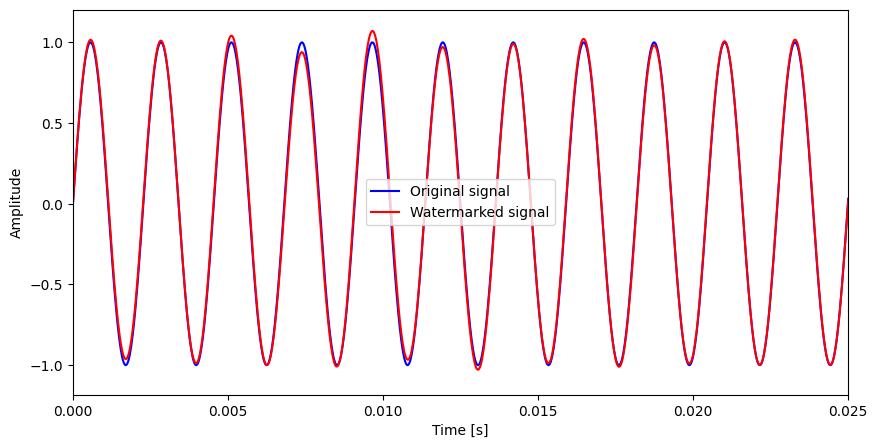

In [21]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t, test_signal, label="Original signal", color=(0, 0, 1.0, 1.0))
plt.plot(t, watermarked_signal_dct, label="Watermarked signal", color=(1.0, 0, 0, 1.0))
plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

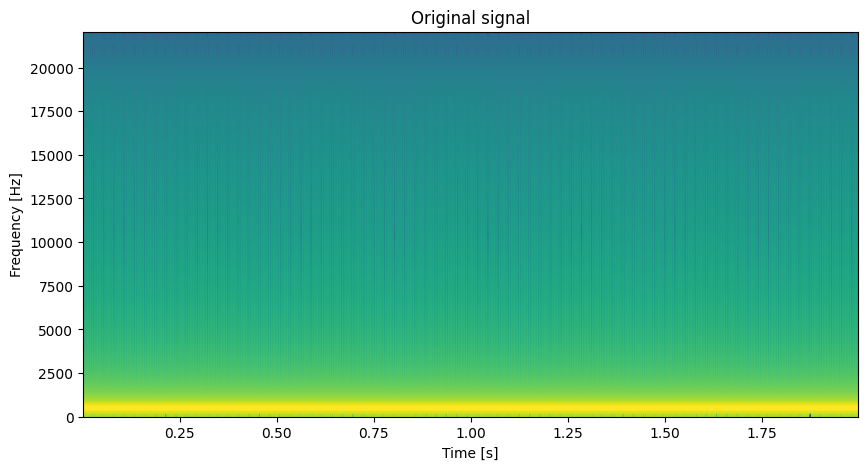

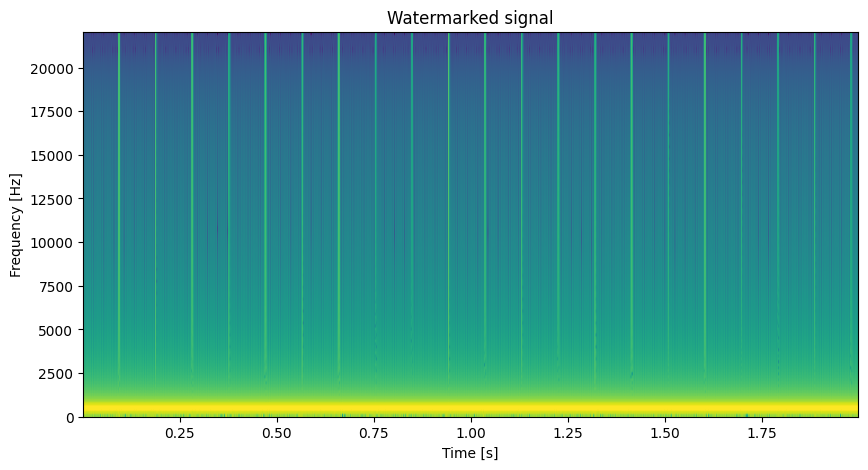

In [22]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(test_signal, Fs=fs)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_dct, Fs=fs)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

hamlet -> convertir a 44100

In [55]:
# Parameters
lt = 23
lw = 1486
lG1 = 24
lG2 = 6
band_size = lG1+lG2

# Create watermark
watermark_lenght_dct = get_watermark_length(signal=hamlet_en, lt=lt, lw=lw, lG1=lG1)
watermark_dct = np.tile(np.array([1, 0]), watermark_lenght_dct//2)

# Embed watermark
watermarked_signal_dct, G1_inds = dctb1_watermark_embedding(signal=hamlet_en, watermark=watermark_dct, sr=fs_hamlet, band_size=band_size, lG1=lG1)

# Detect watermark
detected_watermark_dct = dctb1_watermark_detection(watermarked_signal=watermarked_signal_dct, sr=fs_hamlet, G1_inds=G1_inds, lt=lt, lw=lw, band_size=band_size)

print(f"BER = {calculate_ber(watermark_dct, detected_watermark_dct)*100:.2f}%")
watermarking_methods['dct']['BER [%]'] = calculate_ber(watermark_dct, detected_watermark_dct)*100
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_dct):.2f} dB")
watermarking_methods['dct']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_dct)

2784
BER = 0.79%
SNR = 13.06 dB


In [24]:
# Play watermarked signal
Audio(data=watermarked_signal_dct, rate=fs_hamlet)

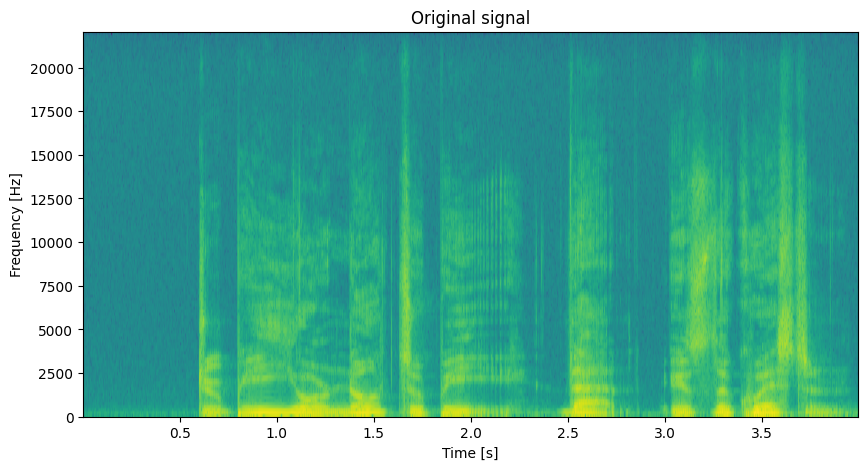

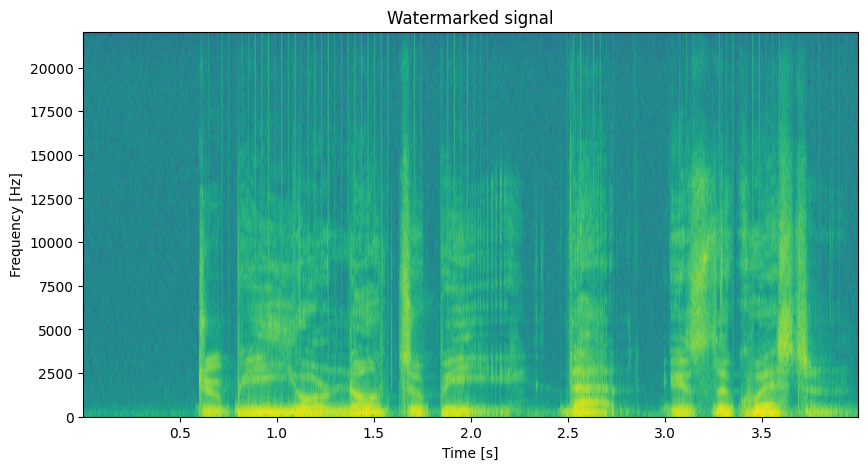

In [25]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_dct, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

### Patchwork

teoria patchwork

In [26]:
# Create a sine wave signal as test signal and an alternating bit sequence as watermark
fs = 16000
t = np.arange(0, 2, 1/fs)
test_signal = np.sin(2*np.pi*440*t)

In [27]:
watermark_patch = np.tile(np.array([1, 0]), 1024)

watermarked_signal_patch = patchwork_watermark_embedding(signal=test_signal, watermark=watermark_patch, sr=fs)

detected_watermark_patch = patchwork_watermark_detection(watermarked_signal=watermarked_signal_patch, watermark_length=len(watermark_patch), sr=fs)

print(f"BER = {calculate_ber(watermark_patch, detected_watermark_patch)*100:.2f}%")

BER = 0.00%


In [28]:
# Play original signal
Audio(data=test_signal, rate=fs)

In [29]:
# Play watermarked signal
Audio(data=watermarked_signal_patch, rate=fs)

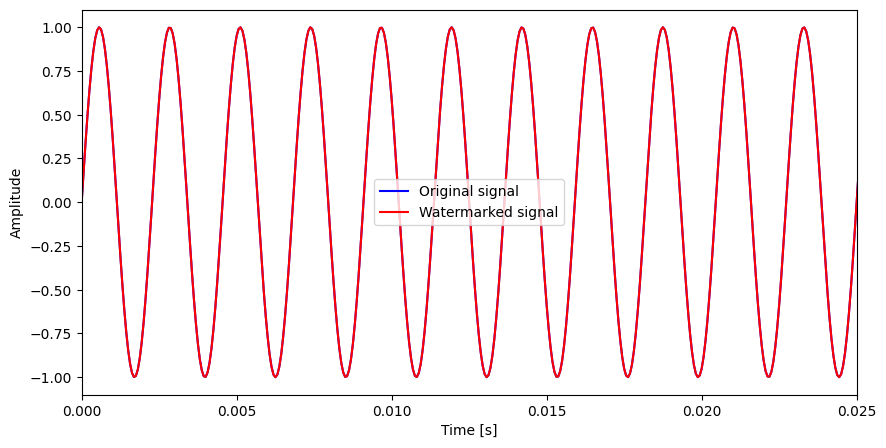

In [30]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t, test_signal, label="Original signal", color=(0, 0, 1.0, 1.0))
plt.plot(t, watermarked_signal_patch, label="Watermarked signal", color=(1.0, 0, 0, 1.0))
plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

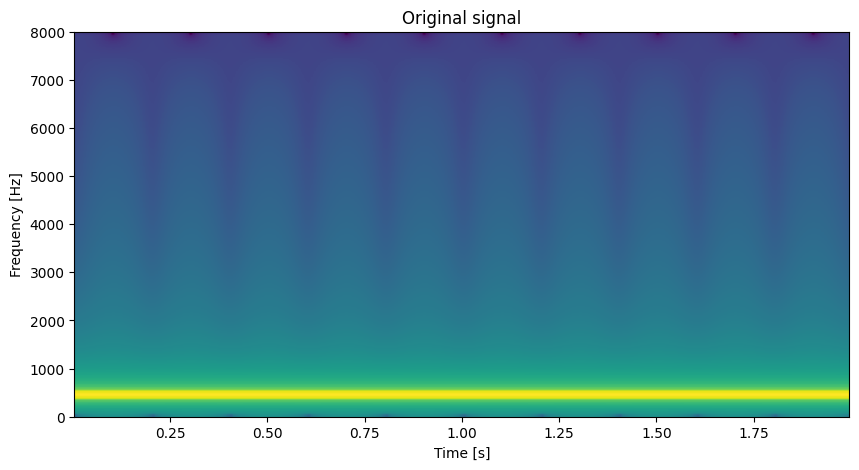

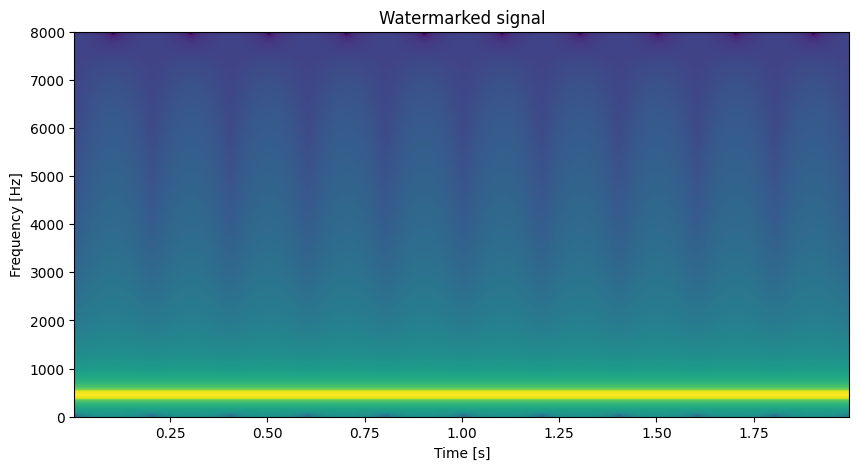

In [31]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(test_signal, Fs=fs)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_patch, Fs=fs)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [32]:
watermark_patch = np.tile(np.array([1, 0]), 2**10)

watermarked_signal_patch = patchwork_watermark_embedding(signal=hamlet_en, watermark=watermark_patch, sr=fs_hamlet)

detected_watermark_patch = patchwork_watermark_detection(watermarked_signal=watermarked_signal_patch, watermark_length=len(watermark_patch), sr=fs_hamlet)

print(f"BER = {calculate_ber(watermark_patch, detected_watermark_patch)*100:.2f}%")
watermarking_methods['patchwork']['BER [%]'] = calculate_ber(watermark_patch, detected_watermark_patch)*100
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_patch):.2f} dB")
watermarking_methods['patchwork']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_patch)

BER = 20.85%
SNR = 34.50 dB


In [33]:
Audio(hamlet_en, rate=fs_hamlet)

In [34]:
Audio(watermarked_signal_patch, rate=fs_hamlet)

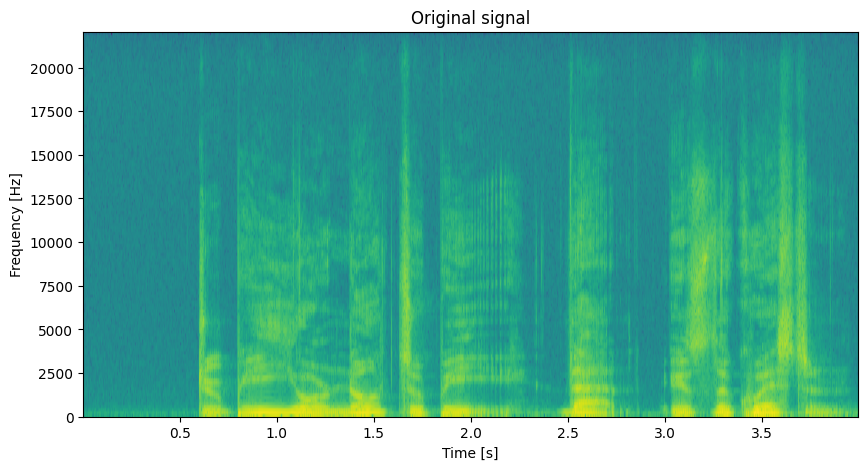

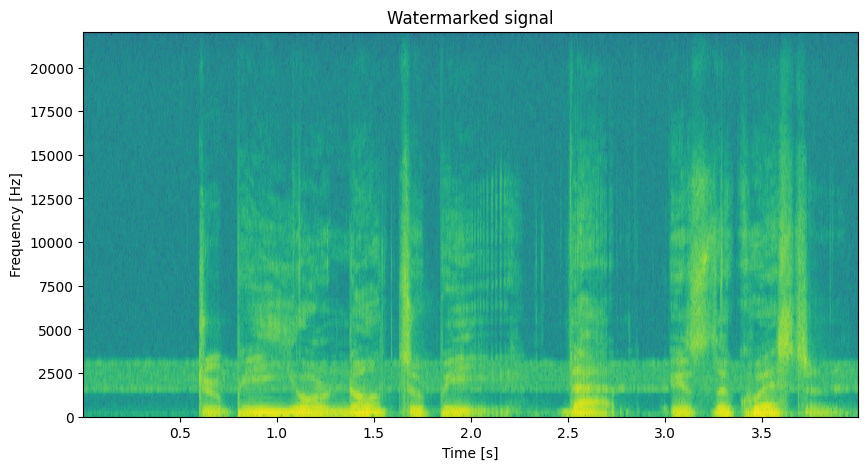

In [35]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_patch, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

### Norm Space

teoria normspace

In [36]:
watermark_ns = np.tile(np.array([1, 0]), len(test_signal)//8)

watermarked_signal_ns = norm_space_watermark_embedding(signal=test_signal, watermark=watermark_ns, delta=0.01)

detected_watermark_ns = norm_space_watermark_detection(watermarked_signal=watermarked_signal_ns, watermark_length=len(watermark_ns), delta=0.01)

print(f"BER = {calculate_ber(watermark_ns, detected_watermark_ns)*100:.2f}%")

BER = 0.00%


In [37]:
# Play original signal
Audio(data=test_signal, rate=fs)

In [38]:
# Play watermarked signal
Audio(data=watermarked_signal_ns, rate=fs)

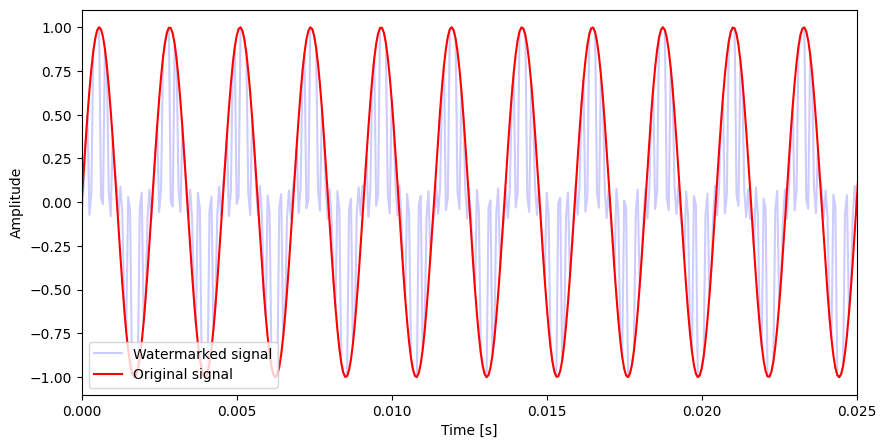

In [39]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t, watermarked_signal_ns, label="Watermarked signal", color=(0.0, 0, 1.0, 0.2))
plt.plot(t, test_signal, label="Original signal", color=(1.0, 0, 0, 1.0))
plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

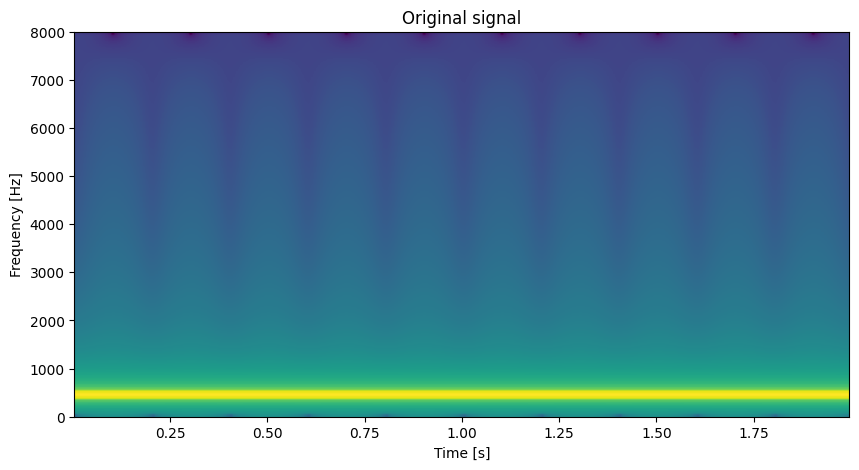

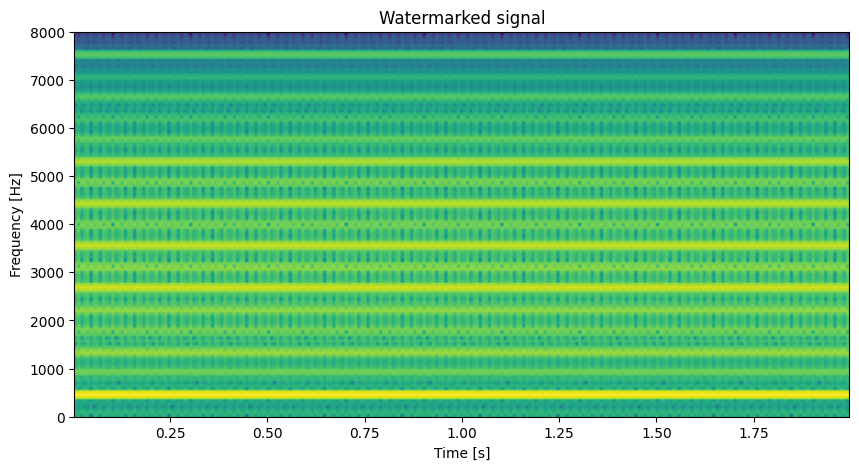

In [40]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(test_signal, Fs=fs)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_ns, Fs=fs)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [41]:
watermark_ns = np.tile(np.array([1, 0]), len(hamlet_en)//16)

watermarked_signal_ns = norm_space_watermark_embedding(signal=hamlet_en, watermark=watermark_ns, delta=0.01)

detected_watermark_ns = norm_space_watermark_detection(watermarked_signal=watermarked_signal_ns, watermark_length=len(watermark_ns), delta=0.01)

print(f"BER = {calculate_ber(watermark_ns, detected_watermark_ns)*100:.2f}%")
watermarking_methods['norm_space']['BER [%]'] = calculate_ber(watermark_ns, detected_watermark_ns)*100
watermarked_signal_ns_snr = np.nan_to_num(watermarked_signal_ns) # to calculate SNR we need to replace NaNs with zeros
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_ns):.2f} dB")
watermarking_methods['norm_space']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_ns_snr)


BER = 0.20%
SNR = nan dB


In [42]:
# Play watermarked signal
Audio(data=watermarked_signal_ns, rate=fs_hamlet)

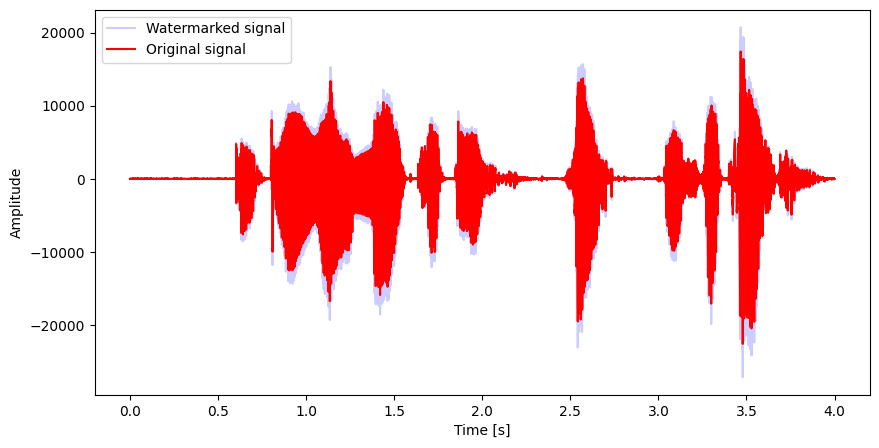

In [43]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t_hamlet, watermarked_signal_ns, label="Watermarked signal", color=(0.0, 0, 1.0, 0.2))
plt.plot(t_hamlet, hamlet_en, label="Original signal", color=(1.0, 0, 0, 1.0))
# plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

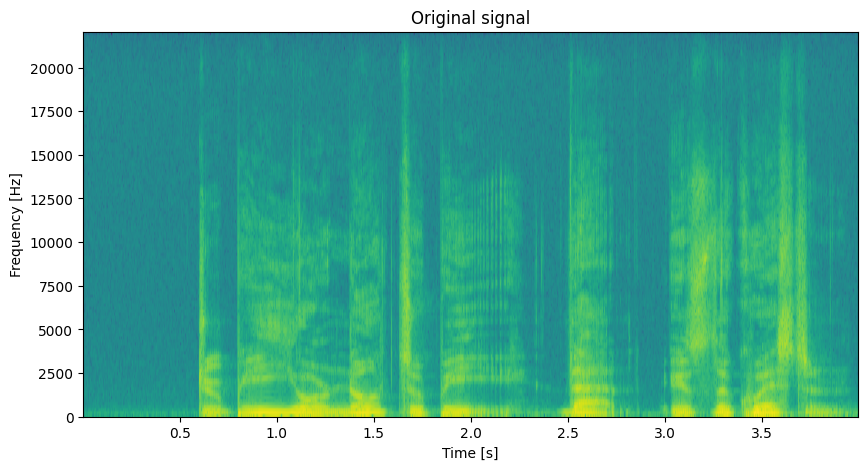

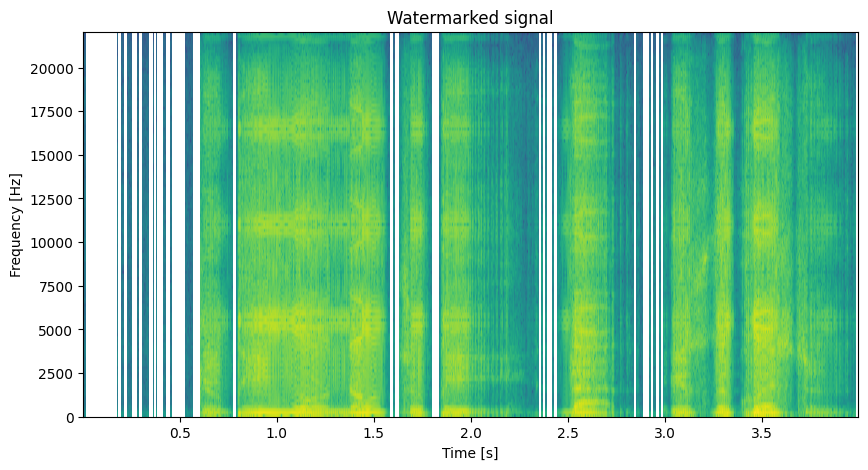

In [44]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_ns, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [45]:
watermarking_methods_df = pd.DataFrame.from_dict(watermarking_methods, orient='index')
watermarking_methods_df = watermarking_methods_df.round(2)
display(watermarking_methods_df)

SNR [dB]  BER [%]
patchwork      34.50    20.85
norm_space      3.58     0.20
dct            13.23     0.65

### FSVC

In [46]:
# Create a sine wave signal as test signal and an alternating bit sequence as watermark
fs = 44100
t = np.arange(0, 2, 1/fs)
test_signal = np.sin(2*np.pi*441*t)

In [47]:
watermark_fsvc = np.tile(np.array([1, 0]), 1024)

watermarked_signal_fsvc = fsvc_watermark_embedding(test_signal, watermark_fsvc, sr=fs)

detected_watermark_fsvc = fsvc_watermark_detection(watermarked_signal_fsvc, sr=fs)

print(f"BER = {calculate_ber(watermark_fsvc, detected_watermark_fsvc)*100:.2f}%")
print(f"SNR = {calculate_snr(test_signal, watermarked_signal_fsvc):.2f} dB")

BER = 0.05%
SNR = 42.00 dB


In [48]:
# Play original signal
Audio(data=test_signal, rate=fs)

In [49]:
# Play watermarked signal
Audio(data=watermarked_signal_fsvc, rate=fs)

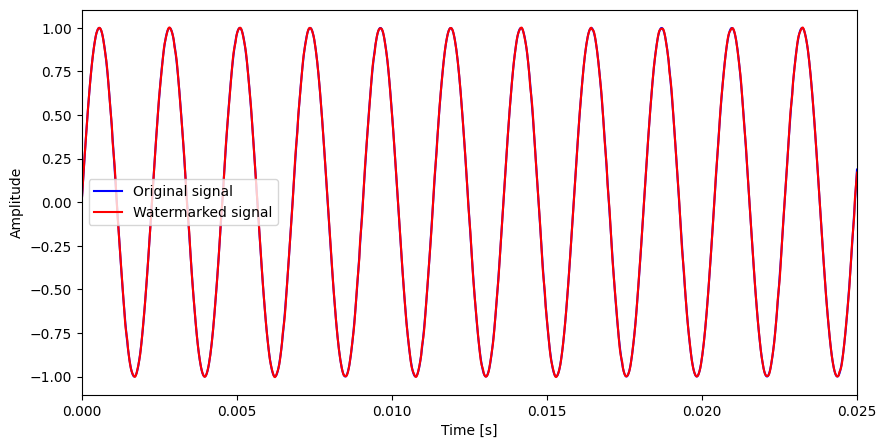

In [50]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t, test_signal, label="Original signal", color=(0, 0, 1.0, 1.0))
plt.plot(t, watermarked_signal_fsvc, label="Watermarked signal", color=(1.0, 0, 0, 1.0))
plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

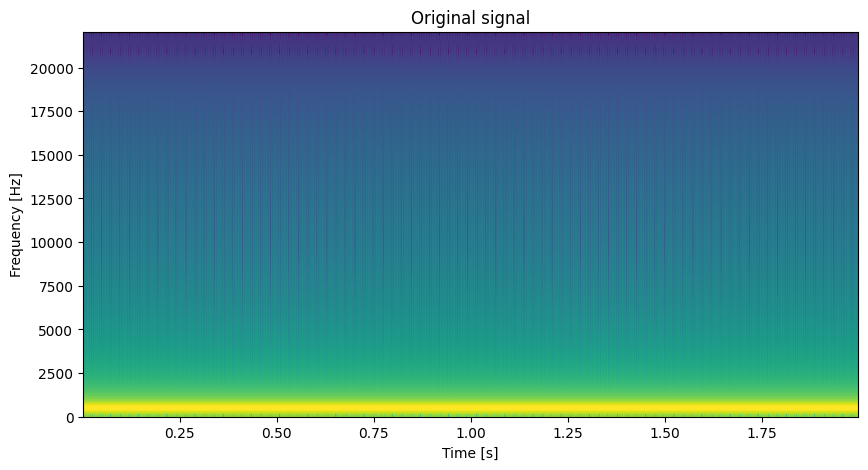

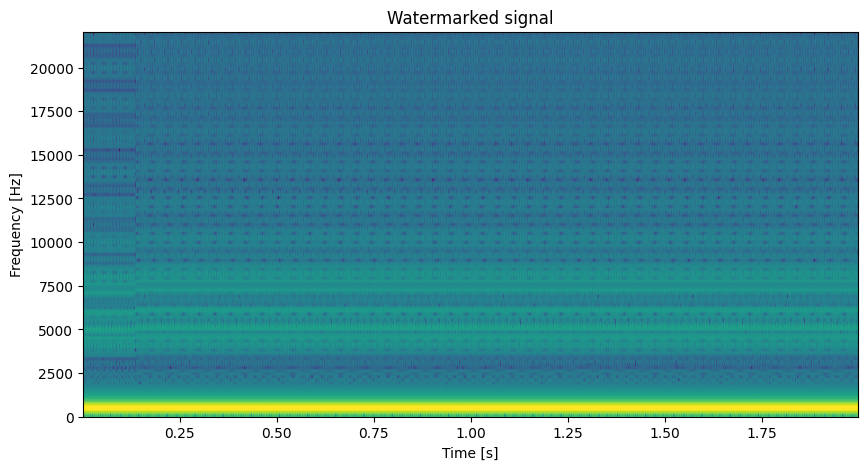

In [51]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(test_signal, Fs=fs)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_fsvc, Fs=fs)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [52]:
watermark_fsvc = np.tile(np.array([1, 0]), 4096)

watermarked_signal_fsvc = fsvc_watermark_embedding(hamlet_en, watermark_fsvc, sr=fs_hamlet)

detected_watermark_fsvc = fsvc_watermark_detection(watermarked_signal_fsvc, sr=fs_hamlet)

print(f"BER = {calculate_ber(watermark_fsvc, detected_watermark_fsvc)*100:.2f}%")
# watermarking_methods['fsvc']['BER [%]'] = calculate_ber(watermark_fsvc, detected_watermark_fsvc)*100
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_fsvc):.2f} dB")
# watermarking_methods['fsvc']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_fsvc)

BER = 0.01%
SNR = 28.16 dB


In [53]:
# Play watermarked signal
Audio(data=watermarked_signal_fsvc, rate=fs_hamlet)

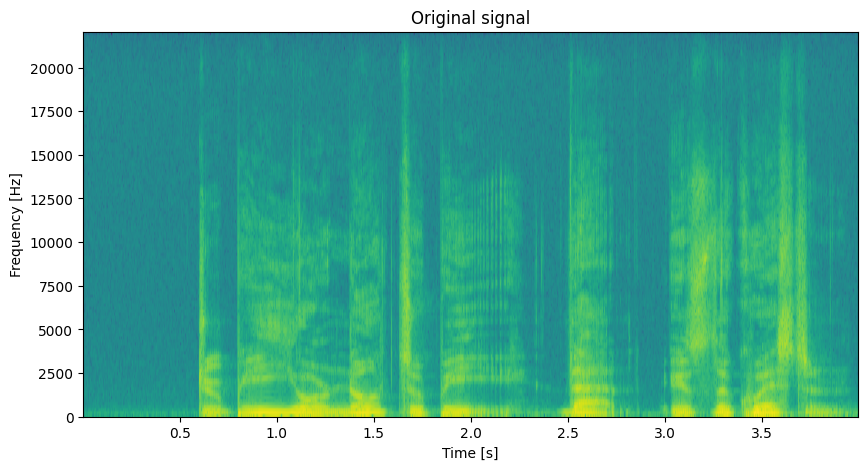

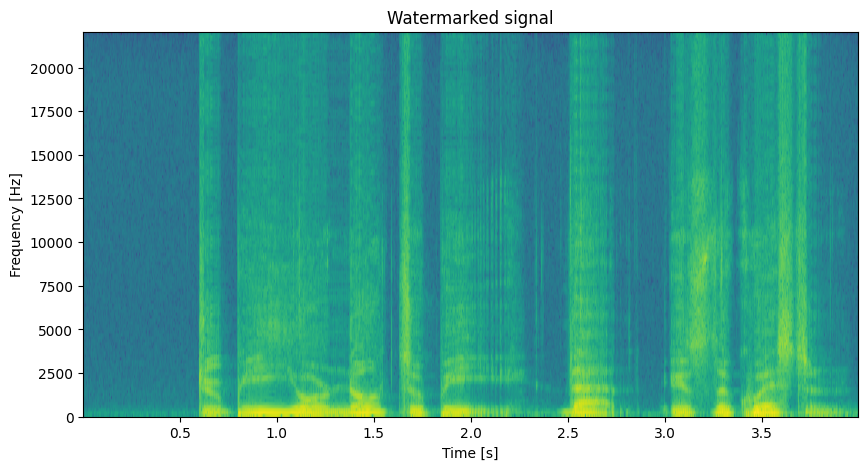

In [54]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_fsvc, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()